## Testing adding a fault to gempy model


In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\elisa\Anaconda3\envs\gempy_n\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implemen

In [20]:
dem_path= os.pardir+"/chloe/DEMraster50_proj_251x200.tif"   #DEM to be used to set model grid (should be rectangular)
intfile = os.pardir+"/chloe/GKgp0101interfaces.csv"
orfile = os.pardir+"/chloe/GKgp0101orientations.csv"

In [21]:

#Manual grid assignment (for debugging):
#if xres=yres, seems to work - but this is incorrect, and why?
#correct values are xres=251, yres=200, zres=26
xmin = 578287.5
xmax = 590837.5
xres = 251                   
dx   = (xmax-xmin)/xres
ymin = 5240062.5
ymax = 5250062.5
yres = 200
dy   = (ymax-ymin)/yres
zmin = 913.0
zmax = 2230.0
zres = 26
dz   = (zmax-zmin)/zres
grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later

print('Grid dimensions:\n', xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz)

Grid dimensions:
 578287.5 590837.5 251 50.0 5240062.5 5250062.5 200 50.0 913.0 2230.0 26 50.65384615384615


[ 578287  590837 5240062 5250062] [200 251]
Cropped raster to geo_model.grid.extent.
[ 578287  590837 5240062 5250062] [200 251]
storing converted file...
obacht


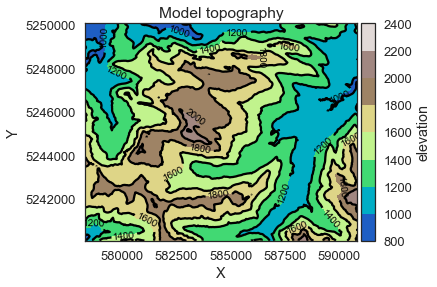

In [22]:
# decreasing model resolution for faster calculation (this does not effect the resolution of dem)
res = [10,12,9]
geo_model = gp.create_model('bla')                                          #create model object
gp.init_data(geo_model, [xmin,xmax, ymin,ymax, zmin,zmax],res,  #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
            path_o = orfile,                                                  #csv file for orientation points: col names are case sensitive, must include at least one point per unit t
            path_i = intfile)                                                 #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit (except faults)


gp.map_series_to_surfaces(geo_model, {'strat': ('Garschella', 'Schrattenkalk', 'Drusberg')})  #set the correct order of series, youngest to oldest
    
#Set grids:
geo_model.set_topography(source='gdal', filepath=dem_path)      #load surface topography from DEM
#geo_model.set_topography(source='random')                       #assign random surface topography

#gp.plot.plot_data(geo_model, direction='z') #plot a map view of the data points
#geo_model.surfaces                          #see order of surfaces (series and formations)
#gp.plot.plot_3D(geo_model)                 #display data in 3D using vtk

In [23]:
import matplotlib

In [24]:
#View and set colors for different units (optional):
colordic = {'Garschella':  matplotlib.colors.cnames['saddlebrown'],
          'Schrattenkalk': matplotlib.colors.cnames['yellowgreen'],
          'Drusberg':      matplotlib.colors.cnames['gold'],
          'basement':      matplotlib.colors.cnames['rebeccapurple']} 
geo_model.surfaces.colors.change_colors(colordic)


,surface,series,order_surfaces,isBasement,color,id
0,Drusberg,strat,1,False,#FFD700,1
1,Garschella,strat,2,False,#8B4513,2
2,Schrattenkalk,strat,3,False,#9ACD32,3
3,basement,Basement,1,True,#663399,4


In [25]:
geo_model.grid.regular_grid.extent

array([5.7828750e+05, 5.9083750e+05, 5.2400625e+06, 5.2500625e+06,
       9.1300000e+02, 2.2300000e+03])

In [26]:
geo_model.grid.topography.extent

array([ 578287,  590837, 5240062, 5250062])

In [31]:
#Calculate model:
gp.set_interpolation_data(geo_model, output='geology', theano_optimizer='fast_compile') #compile theano and interpolate the input data - if topo, need to set output='geology'
#gp.set_interpolation_data(geo_model, theano_optimizer='fast_compile') #compile theano and interpolate the input data

sol = gp.compute_model(geo_model, compute_mesh=True)               #compute the model from the data - returns an output (sol) which includes lith and faults, each with two arrays, one for the id of the formation in each cell, one with orientations in each cell
#need to set compute_mesh=True in order to see the interfaces in 3D
#if compute_mesh=False, model computes geologic map but not interfaces in 3D

#print('Model computed. Available methods:', dir(sol))        #print list of methods available for model results

Compiling theano function...
Compilation Done!


In [32]:
geo_model.grid.regular_grid.mask_topo.shape

(10, 12, 9)

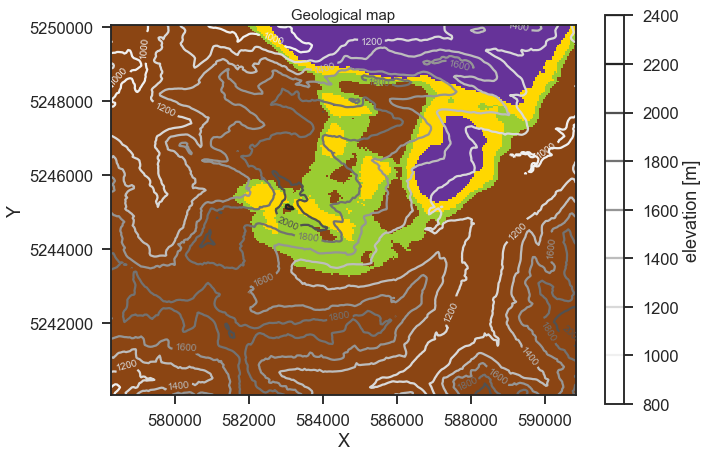

In [33]:
gp.plot.plot_map(geo_model, contour_lines=True)    

In [35]:
#Check dimensions
print(sol.geological_map.shape)
print(xres*yres)
print(sol.grid.values.shape)
print(xres*yres*zres)

#Plot true geologic map for comparison:
m = np.flipud(np.reshape(sol.geological_map, (yres,xres)))  #reshape gempy geologic map array to be north-oriented 2D array
#mapping.export2gslib(os.path.join(data_path,gpRunID+gslib_file_2Dcrop), m, grid_info) #export gempy map to gslib file 
#f = mapping.compare_geology(os.path.join(data_path,gpRunID+gslib_file_2Dcrop), true_geol_path , grid_info, colors=colordic)  #plot (why does this plot twice?)

(1, 50200)
50200
(51280, 3)
1305200


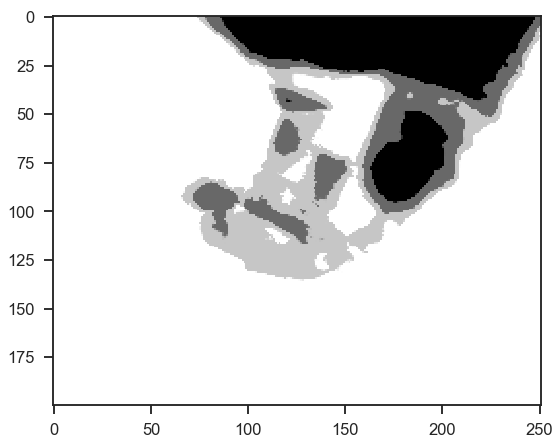

In [36]:
plt.imshow(m)

### Manually crop to topo to compare

In [41]:
import gdal
import pandas as pd

In [42]:
dem = gdal.Open(dem_path)

In [ ]:
#Crop with topography and model boundary polygon:
translate_options = gdal.TranslateOptions(options = ['format'],format = "XYZ")  #set options for gdal.Translate()
gdal.Translate('DEMxyz.csv', dem, options=translate_options)  #convert dem to a csv with one column of points, each with an xyz value
xyz = pd.read_csv('DEMxyz.csv', header=None, sep = ' ')       #read xyz csv with pandas
demlist = xyz.values                                          #convert to np array of (x,y,z) values with dim (ncol*nrow, 3)

In [48]:
geo_model.grid.set_custom_grid(demlist)    
sol = gp.compute_model(geo_model, set_solutions=False)

In [49]:
geo_model.grid.active_grids

array([ True,  True,  True, False])

In [50]:
l0, l1 = geo_model.grid.get_grid_args('custom')
section = sol[0][:, l0: l1]

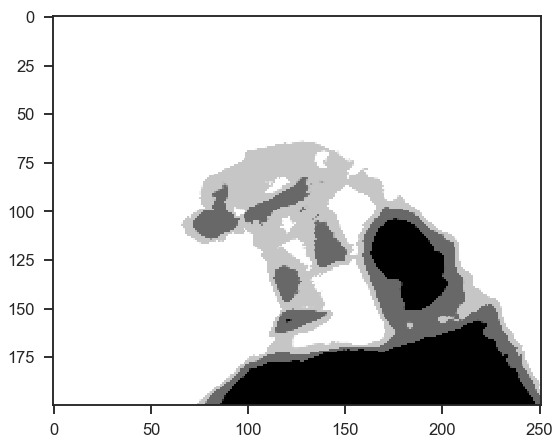

In [51]:
plt.imshow(section.reshape(geo_model.grid.topography.resolution))